
<div class="page-header">
  <h1>大作业 <small>作者：2007010218 孙百乐 2007020220 孙鹏程 2007040103 蒋月宁</small></h1>
</div>

<div class="alert alert-success" role="alert"><h1>第一部分：数据获取</h1></div>

In [24]:
#环境准备
import re
import requests
import numpy as np
import pandas as pd
import PIL.Image as image
import matplotlib.pyplot as plt
from pathlib import Path
from bs4 import BeautifulSoup as BS
from mpl_toolkits.mplot3d import Axes3D
from wordcloud import WordCloud,ImageColorGenerator
%matplotlib inline

## 基础类Words

爬取网页单词，对爬取的单词进行初步处理。

包括：分词处理；利用百度停用词表清洗单词；计算单词的词频frequency、计数count并做数据聚合，形成单词表。

In [25]:
class Words:
    
    # 获取网页源代码函数
    def get_source(self,url):
        html_source = requests.get(url).text
        return html_source
    
    #网页解析函数
    def get_text(self,html_source):
        soup = BS(html_source)
        html_text = soup.get_text()
        title = soup.title.string
        return title,html_text
    
    #分词函数
    def cut_words(self,html_text):
        word_cut = re.split("""[ ,.\(\)/\n|\-:=\$\["']""",html_text)
        return word_cut
    
    #读取百度停用词表，stopwords是类变量
    stopwords = Path('baidu_stopwords.txt',encoding='utf-8').read_text(encoding='utf-8').split('\n')
    
    #单词清洗函数
    def word_clean(self,word_cut,stopwords):
        word_clean = []
        for word in word_cut:
            word = str(word).lower().strip()  
            # 过滤掉空词、数字、单个字符的词、停用词
            if not word or word.isnumeric() or len(word)<=1 or word in stopwords:
                continue
            word_clean.append(word)
        return word_clean
    
    #构造Dataframe，并做数据聚合
    def get_words_count(self,word_clean):
        df_words = pd.DataFrame({"word": word_clean})
        words_count = (df_words.groupby('word')['word'].agg(count='size').reset_index()
                    .sort_values(by="count", ascending=False))
        words_count['frequency'] = words_count['count']/len(self.word_clean)#词频
        return words_count
    
    def __init__(self,url):
        self.url = url
        self.html_source = self.get_source(url)
        self.title,self.html_text = self.get_text(self.html_source)
        self.word_cut = self.cut_words(self.html_text)
        self.word_clean = self.word_clean(self.word_cut,self.stopwords)
        self.words_count = self.get_words_count(self.word_clean)

## 类Trans

该类继承自基础类Words。主要功能：实现用两种方法对单词 dataframe 的翻译，分别是在线百度翻译和离线词典翻译；然后再单独列出单词的词性。

In [26]:
class Trans(Words):
    #这是一个apply函数，用爬虫的方法获取百度翻译
    @staticmethod
    def get_translation(word):
        url = 'https://fanyi.baidu.com/sug' #请求url

        # 构造头部信息，该信息可以将我们的脚本伪装成浏览器访问
        headers={
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.79 Safari/537.36',
        }
        #提交的表单数据
        data={'kw':word}

        # 开始请求,为POST请求
        response=requests.post(url=url,headers=headers,data=data)
        #打印响应内容
        if response.status_code==200:
            res_json = response.json()
        # res_json
            try:
                return res_json['data'][0]['v']
            except:
                return 'error'
            
    #使用百度翻译进行翻译，新增一列translation_baidu,这个真的很慢，所以设置为静态方法，不轻易调用
    @staticmethod
    def get_trans_baidu(df):
        df['baidu_translation'] = df['word'].apply(Trans.get_translation)
        return df
    
    #读取github上的离线词典
    df_dict = pd.read_csv("stardict.csv",usecols=["word", "translation"]).rename(columns={'translation':'github_translation'})

    #使用github上的离线词典进行翻译的函数运行速度较慢
    def get_trans_github(self):
        df_merge = pd.merge(
        left = Trans.df_dict,
        right = self.words_count,
        left_on = "word",
        right_on = "word"
        )
        order = ['word','count','frequency','github_translation']
        return df_merge[order]
    
    #不仅获取翻译，而且新增一列词性
    def get_part_of_speech(self):
        df = self.get_trans_github()
        def apply_fun(x):
            try:
                judge = x.split('.')[1] #如果split完之后列表里只有一个元素，这一句就会报错
                part_of_speech = x.split('.')[0]+'.'
                return part_of_speech
            except:
                return 'unkown'
        df['part_of_speech'] = df['github_translation'].apply(apply_fun)
        return df
    
    def __init__(self,url):
        super().__init__(url)
        self.github_trans = self.get_trans_github()
        self.part_of_speech = self.get_part_of_speech()

## 类Cet4

该类继承自类Trans。

主要功能：标记四级词汇。下载四级单词文本文件，用正则表达式提取其中的四级单词，形成一个集合；添加新列，判断是否属于四级汇，该列的数据类型为 boolean；对四级单词特殊标记，设置背景颜色为荧黄色；导出为 excel 文件。

In [27]:
class Cet4(Trans):
    CET4 = Path('CET4_word.txt').read_text(encoding='utf8')

    CET4 = re.sub(r'\[.+\]','*',CET4)
    CET4 = re.sub(r'/(.+?)/','*',CET4)#替换音标
    CET4 = re.sub(r'\w{1,2}\.','=',CET4)#替换词性

    pattern = re.compile(r'([a-z]+)')

    CET4_lst = pattern.findall(CET4)
    CET4_set = set(CET4_lst)
    
    #添加新列，数据类型为boolean，判断是否属于四级词汇
    def mark_cet4(self,df):
        df['Is_CET4'] = df['word'].isin (self.CET4_set)
        return df
    
    #一个用于设置背景颜色的作用于df.style的apply函数
    def set_color(col):
        return ['background-color:yellow' if x in Cet4.CET4_set else '' for x in col]
    
    #产生标记好背景颜色的df
    def mark_cet4_style(self,df):
        style = df.style.apply(Cet4.set_color)
        return style
    
    #导出带样式的excel文件
    def to_excel(self,filename):
        self.cet4_style.to_excel(filename, engine='openpyxl')
    
    def __init__(self,url):
        super().__init__(url)
        self.cet4 = self.mark_cet4(self.part_of_speech)
        self.cet4_style = self.mark_cet4_style(self.cet4)

<div class="alert alert-success" role="alert"><h1>第二部分：对单一页面文本的可视化分析</h1></div>

## 绘制词云

我们在 china daily 上找到一篇关于“5G”的文章，绘制词云如下：

In [28]:
c=Words('https://www.chinadaily.com.cn/a/202105/08/WS60965a22a31024ad0babcba2.html')

(-0.5, 399.5, 399.5, -0.5)

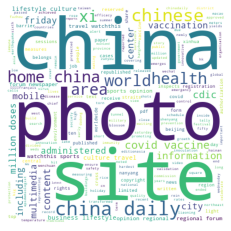

In [29]:
wl = " ".join(c.word_clean)
cloud = WordCloud(background_color="white",width=400,height=400).generate(wl)
plt.imshow(cloud)
plt.axis('off')

我们发现，该词云显示了“china”、“china daily”等非关键词。于是在删除了无关词汇后对其进行美化，得到下图：

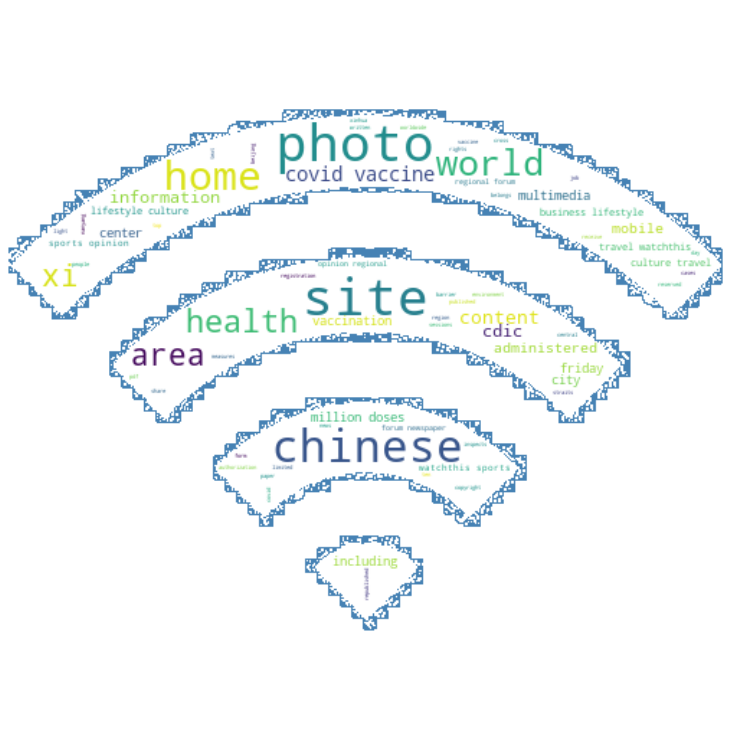

In [30]:
tool = []
for i in c.word_clean:
    if i != 'china' and i!='daily':
        tool.append(i)
wlc = " ".join(tool)
# print(wlc)

#自定义词云
mask = np.array(image.open('WiFi.jpg'))
wc = WordCloud(background_color='white', 
                # 遮罩层,除白色背景外,其余图层全部绘制（之前设置的宽高无效）
                 mask=mask, 
                #当参数为“RGBA”并且background_color不为空时，背景为透明
                mode='RGB',
                #调整大小
                width=800, 
                height=800,
                #词数上限
                max_words=1000, 
                #为每个单词返回一个PIL颜色
                random_state=1, 
                contour_width=1, 
                contour_color='steelblue')
wc.generate(wlc)
#调整尺寸
plt.figure(figsize=(10, 10))
#隐藏坐标轴
plt.axis('off')
#显示一下
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)

## 绘制 3D 柱状图

我们找到一篇关于五一劳动节庆祝盛典的英文文章。在获取到单词表后，把单词按照词性分组，并统计出每种词性的单词数量。

绘制 3D 柱状图如下,展现单词的词性与词频的分布情况：

<IPython.core.display.Javascript object>


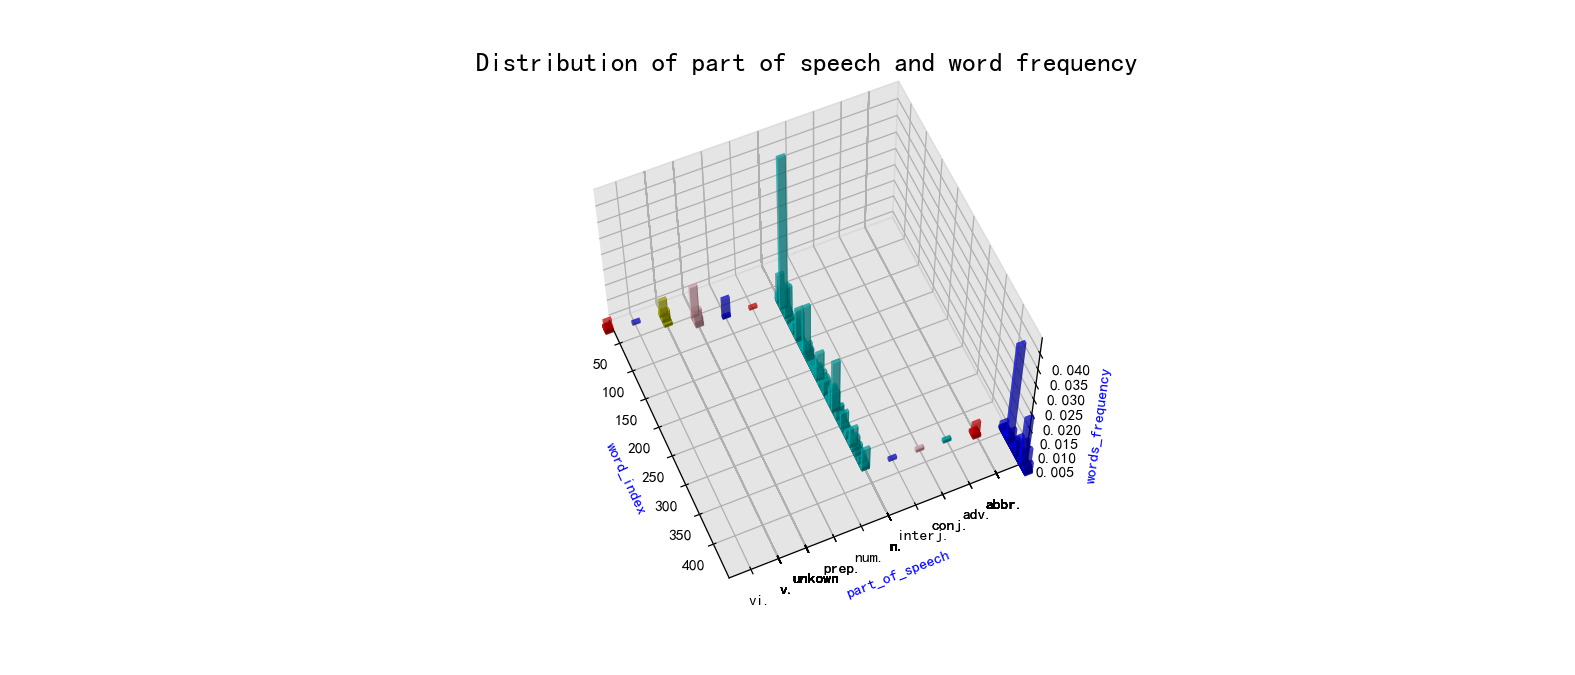

In [31]:
b=Trans('http://www.chinadaily.com.cn/a/202105/03/WS608f3fd5a31024ad0babbc55.html')

b=b.part_of_speech.sort_values(by="part_of_speech" , ascending=False)
b['index']=range(0,len(b['word']))
b['counts']=[1]*len(b['word'])

a=b.groupby('part_of_speech')['counts'].sum()

%matplotlib notebook
plt.rcParams['figure.figsize'] = (14,6)
fig = plt.figure()
ax = fig.gca(projection='3d')  

#len_XZ表示X、Z轴需要截取的数据长度
len_XZ= a['vt.']+a['vi.']+a['v.']+a['unkown']+a['prep.']+a['num.']+a['n.']+a['interj.']+a['conj.']+a['adv.']+a['abbr.']+a['a.']

#lst表示Y轴标签
lst=['vt.']*a['vt.']+['vi.']*a['vi.']+['v.']*a['v.']+['unkown']*a['unkown']+['prep.']*a['prep.']+['num.']*a['num.']+['n.']*a['n.']+['interj.']*a['interj.']+['conj.']*a['conj.']+['adv.']*a['adv.']+['abbr.']*a['abbr.']+['a.']*a['a.']

#设置轴数据
X = b['index'][:len_XZ]
Y = [1]*a['vt.']+[2]*a['vi.']+[3]*a['v.']+[4]*a['unkown']+[5]*a['prep.']+[6]*a['num.']+[7]*a['n.']+[8]*a['interj.']+[9]*a['conj.']+[10]*a['adv.']+[11]*a['abbr.']+[12]*a['a.']
Z = b['frequency'][:len_XZ]

#画图
for xx,yy,zz in zip(X,Y,Z):
    ax.bar3d(xx,yy,0,dx=5,dy=0.3,dz=zz,color='r' if yy==1 else 'b' if yy==2 else 'y' if yy==3 else 'pink' if yy==4 else 'b' if yy==5 else 'r' if yy==6 else 'c' if yy==7 else 'y' if yy==7 else 'pink' if yy==9 else 'c' if yy==10 else 'r' if yy==11 else 'b', alpha=0.5)

#设置坐标轴
ax.set_zlabel('words_frequency',color='b')
ax.set_ylabel('part_of_speech',color='b')
ax.set_xlabel('word_index',color='b')
plt.yticks(Y,lst,color='black') 
plt.title('Distribution of part of speech and word frequency',fontsize='xx-large',fontweight='heavy')

#设置背景颜色
ax.w_xaxis.set_pane_color((0.8, 0.8, 0.8, 0.5))
ax.w_yaxis.set_pane_color((0.8, 0.8, 0.8, 0.5))
ax.w_zaxis.set_pane_color((0.8, 0.8, 0.8, 0.5))

#保存
fig.savefig('Distribution of part of speech and word frequency.png')
plt.show()

<div class="alert alert-success" role="alert"><h1>第三部分：对多个页面文本的可视化分析</h1></div>

##  页面相似度分析

我们找到 china daily 上的两篇文章，分别关于“新冠肺炎”和“五一小长假”。去除无关单词之后，将二者词频最高的 20 个单词进行 merge，并赋值缺失值为 0，画出“不同文章的单词词频分布折线图”，如下图。

<IPython.core.display.Javascript object>


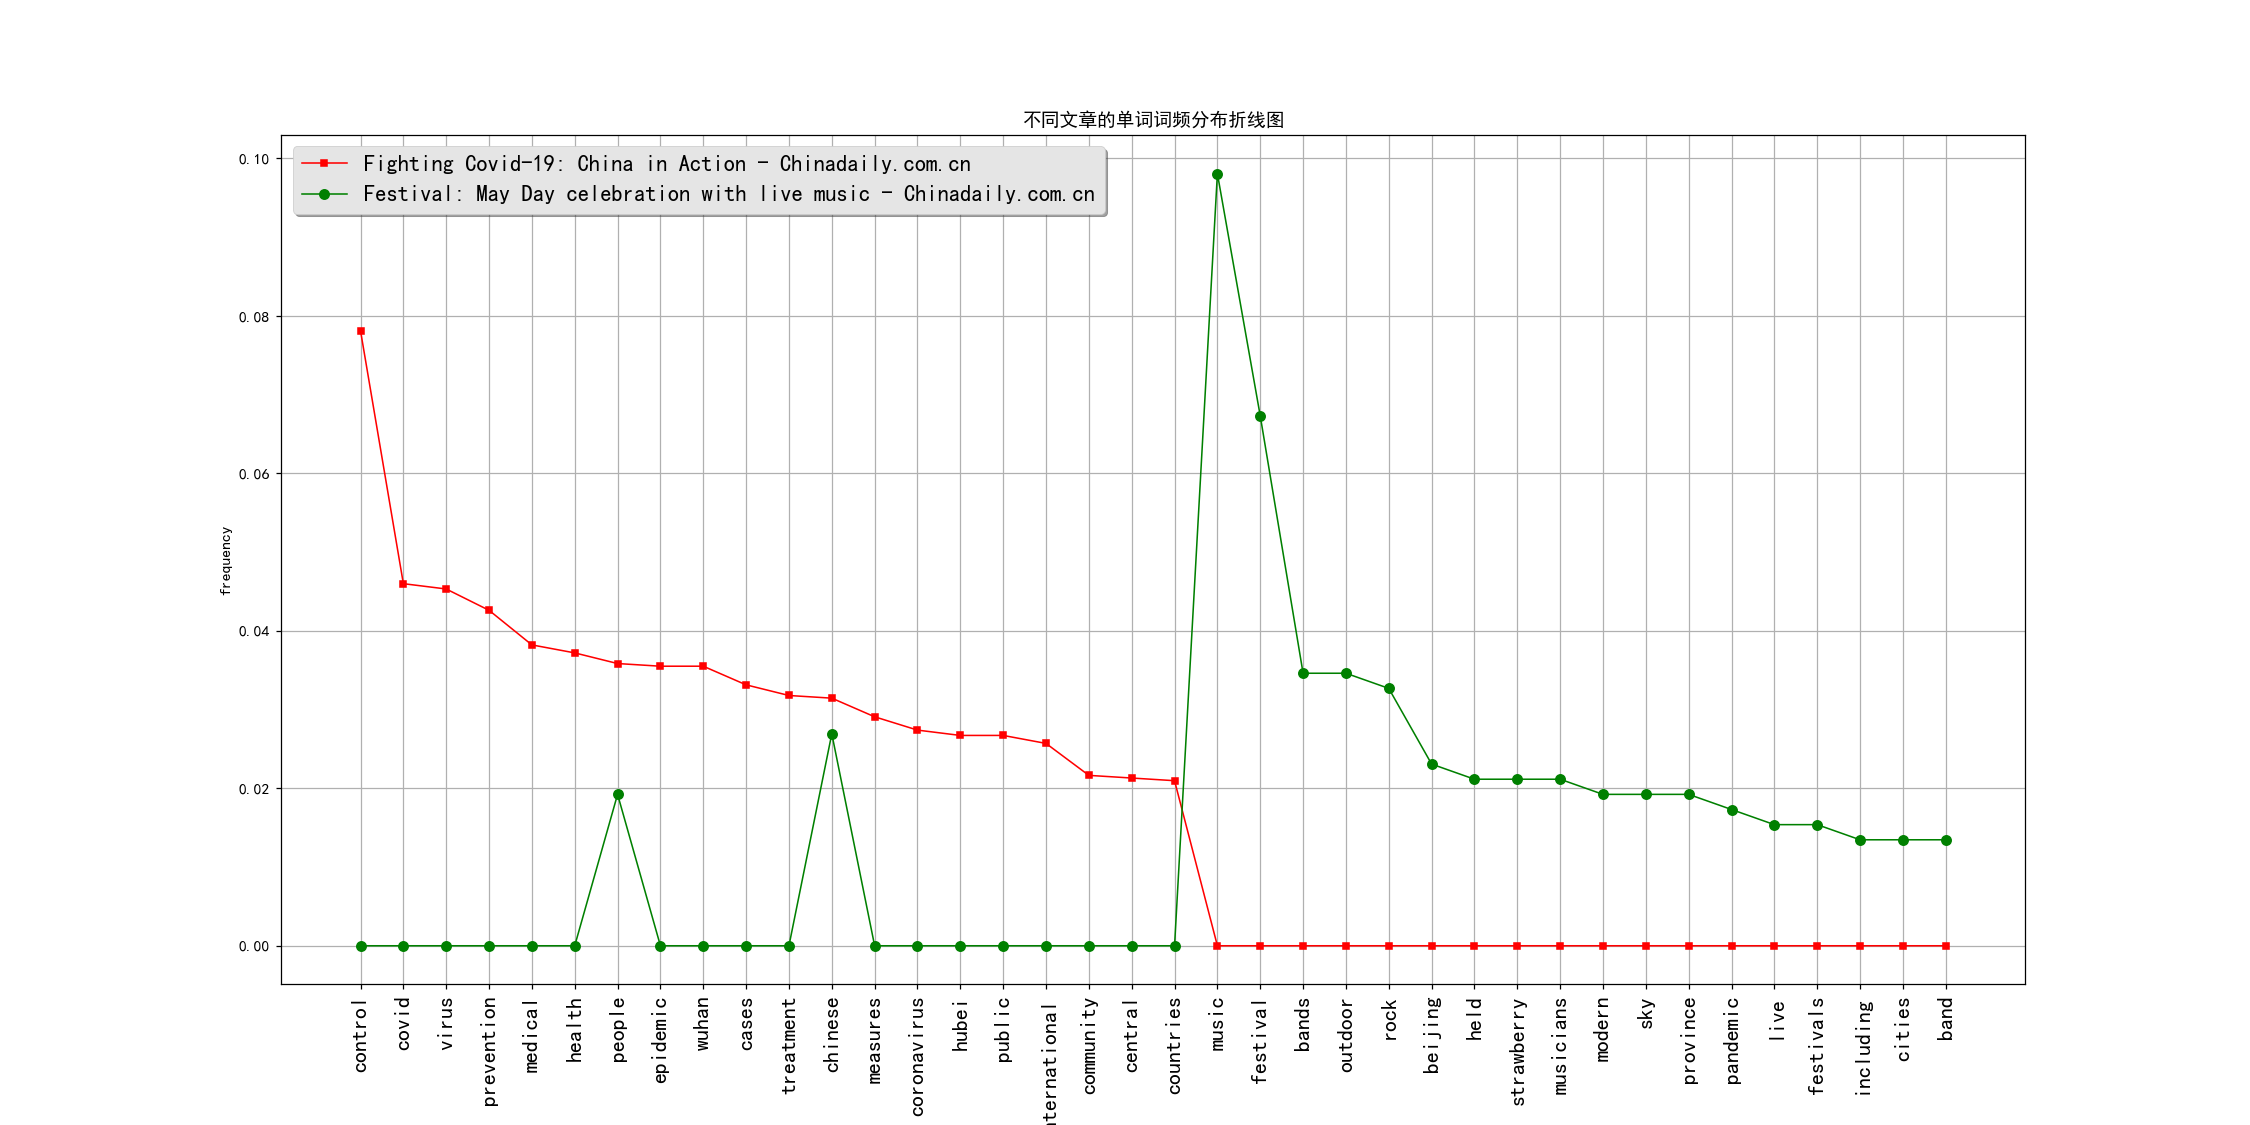

In [32]:
words1 = Words('https://epaper.chinadaily.com.cn/a/202006/08/WS5edd76f5a3107831ec752924.html') #covid-19
words2 = Words('http://www.chinadaily.com.cn/a/202105/03/WS608f3fd5a31024ad0babbc55.html')#May Day

def get_frequency(df,num):
    drop_df = df.drop(df[(df['word']=='china') | (df['word']=='xi') | (df['word']=='daily')].index)
    cut_df = drop_df[:num].copy()
    cut_df['frequency'] = drop_df['count']/len(drop_df)
    return cut_df

a = get_frequency(words1.words_count,20)
b = get_frequency(words2.words_count,20)

merge = pd.merge(
    left = a,
    right = b,
    left_on = "word",
    right_on = "word",
    suffixes=('_1','_2'),
    how='outer'
)
merge_res = merge.fillna(0) #缺失值处理
merge_res

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.figure(figsize=(20,10))
plt.title('不同文章的单词词频分布折线图')
plt.grid(True)#网格线
plt.style.use('ggplot')#灰底风格
plt.plot(merge_res.loc[:,'word'], merge_res.loc[:,'frequency_1'], lw=1, c='red', marker='s', ms=4, label=words1.title)  # 绘制y1
plt.plot(merge_res.loc[:,'word'], merge_res.loc[:,'frequency_2'], lw=1, c='g', marker='o', label=words2.title)  # 绘制y2

plt.ylabel('frequency')  # y轴标注
# 设置 x 坐标轴标签的显示内容和大小
plt.xlabel('Words', fontsize=14)
plt.xticks(rotation=90, fontsize=14)# 设置 x 坐标轴刻度的旋转方向和大小
plt.legend(loc='best', shadow=True, fontsize='x-large')  # 图例
# plt.show()
plt.savefig('不同文章的单词词频分布折线图.jpg')

## 词云多子图

对于多个页面，我们可以绘制如下多子图。

In [33]:
words1 = Words("https://www.chinadaily.com.cn/a/202105/08/WS60965a22a31024ad0babcba2.html")
words2 = Words("https://www.chinadaily.com.cn/a/202105/08/WS6091e017a31024ad0babbf9e.html")
words3 = Words("https://www.chinadaily.com.cn/a/202105/07/WS60950615a31024ad0babc8e8.html")
words4 = Words("https://www.chinadaily.com.cn/a/202105/07/WS60950ac5a31024ad0babc906.html")

words1.words_count

,word,count,frequency
34,china,19,0.042986
223,site,7,0.015837
58,daily,7,0.015837
53,covid,7,0.015837
36,chinese,6,0.013575
...,...,...,...
114,important,1,0.002262
115,imported,1,0.002262
117,industry,1,0.002262
119,innovation,1,0.002262


<IPython.core.display.Javascript object>


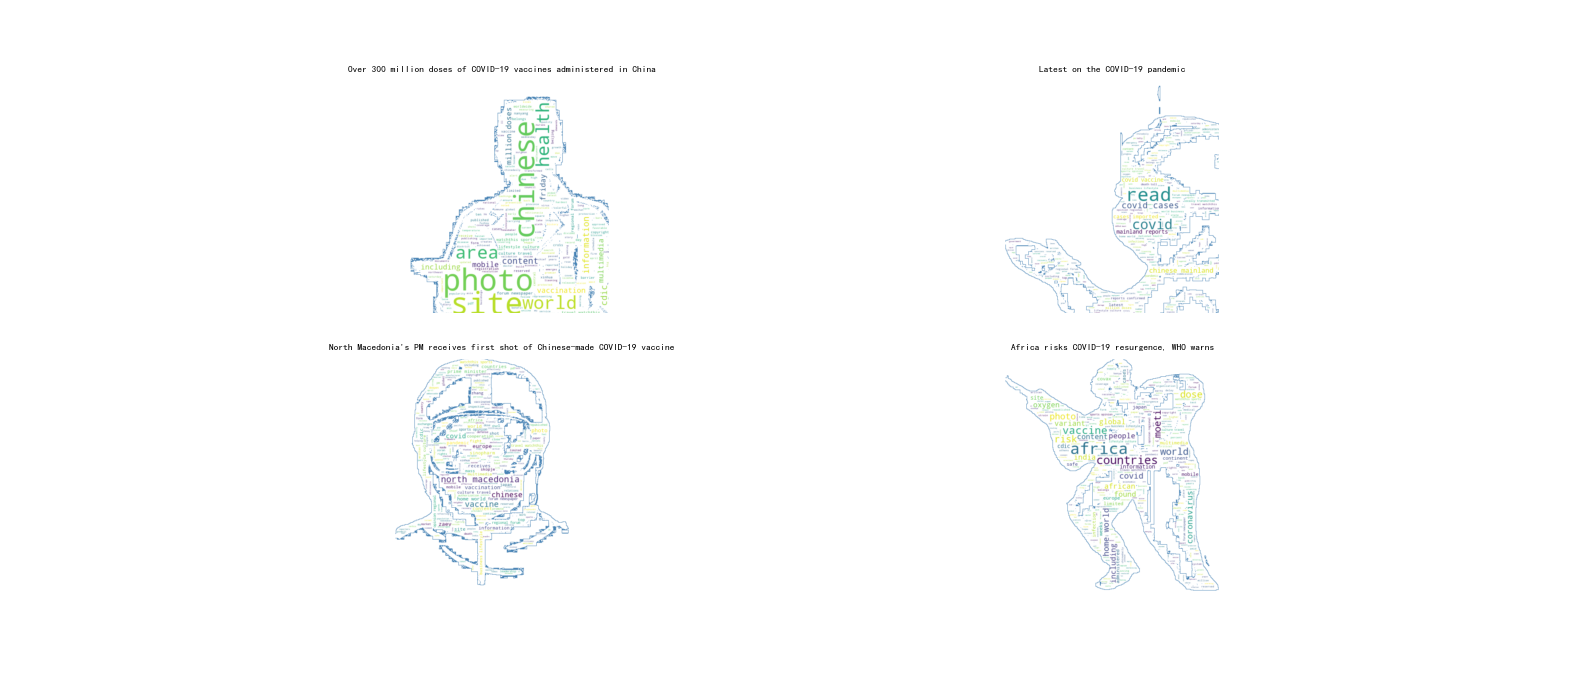

In [34]:
def make_worldcloud(words_word_clean,picture):
    tool = []
    for i in words_word_clean:
        if i != 'china' and i!='daily':
            tool.append(i)
            
    wlc = " ".join(tool)
    # print(wlc)

    #自定义词云
    mask = np.array(image.open(picture))
    wc = WordCloud(background_color='white', 
                    # 遮罩层,除白色背景外,其余图层全部绘制（之前设置的宽高无效）
                   mask=mask, 
                   #当参数为“RGBA”并且background_color不为空时，背景为透明
                   mode='RGB',
                   #调整大小
                   width=800, 
                   height=800,
                   #词数上限
                   max_words=1000, 
                   #为每个单词返回一个PIL颜色
                   random_state=1, 
                   contour_width=1, 
                   contour_color='steelblue')
    wc.generate(wlc)
    '''
    #调整尺寸
    plt.figure(figsize=(10, 10))
    #隐藏坐标轴
    plt.axis('off')
    #显示一下
    plt.imshow(wc1, interpolation='bilinear')
    plt.tight_layout(pad=0)
    #这样可以看单独的某一张,需要即可拿来看
    '''
    return wc
    
rows,cols = 2,2
fig,axs = plt.subplots(rows,cols,sharex=True,sharey=True)
ax = plt.gca()

plt.xticks([])
plt.yticks([])

axs[0, 0].imshow(make_worldcloud(words1.word_clean,"医生照片1.jpg"), interpolation='bilinear')
axs[0, 0].set_title('Over 300 million doses of COVID-19 vaccines administered in China',size = 6)

axs[0, 1].imshow(make_worldcloud(words2.word_clean,"医生照片2.png"), interpolation='bilinear')
axs[0, 1].set_title('Latest on the COVID-19 pandemic',size = 6)

axs[1, 0].imshow(make_worldcloud(words3.word_clean,"医生照片3.png"), interpolation='bilinear')
axs[1, 0].set_title("North Macedonia's PM receives first shot of Chinese-made COVID-19 vaccine",size = 6)

axs[1, 1].imshow(make_worldcloud(words4.word_clean,"医生照片4.png"), interpolation='bilinear')
axs[1, 1].set_title("Africa risks COVID-19 resurgence, WHO warns",size = 6)


for i in range(2):
    for j in range(2):
        #axs[i,j].hist(np.random.randn(500),bins=50,color='k',alpha=0.5)  #这行代码的效果是调整图片大小，实测效果不如不用
        axs[i,j].axis('off')
        
'''
wspace 和 hspace分别控制的是图片的宽度和高度百分比
'''
plt.subplots_adjust(wspace=0)  # 将宽度百分比缩小到零

plt.show()
fig.savefig('./subplot duozitu.jpg',dpi=400) #保存图片，清晰度400

<div class="alert alert-info" role="alert"><h1>所用外部文件</h1></div>
<ul class="list-group">
  <li class="list-group-item">离线词典 https://github.com/skywind3000/ECDICT</li>
  <li class="list-group-item">百度停用词表 https://github.com/goto456/stopwords</li>
  <li class="list-group-item">四级单词表 该链接已失效</li>
</ul>

<div class="alert alert-warning" role="alert">因为离线词典过大（200mb）所以没有上传</div>